This neural network classifies images of leaf diseases based on a [PlantVillage dataset](https://data.mendeley.com/datasets/ngdgg79rzb/1). It uses the MobileNet architecture as a feature extractor and a densely connected layer as classifier. Note that this experiment uses the dataset as-is, without any data augmentation and having severe class imbalance. Nonetheless, the network reports an F1 score of 98%. In a future experiment, class weighting will be applied so that the network has higher loss for minority classes.

@author Jose Enrique R. Lopez<br />
@date-created 8 November 2020

# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
mobile = tf.keras.applications.mobilenet.MobileNet()

2021-11-27 09:45:46.942116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 09:45:47.050421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 09:45:47.051245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 09:45:47.052420: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

   16384/17225924 [..............................] - ETA: 0s

 9256960/17225924 [===============>..............] - ETA: 0s

17227776/17225924 [==============================] - 0s 0us/step


17235968/17225924 [==============================] - 0s 0us/step


# Utility Functions

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
classes = ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Leaf_mold', 'Septorial_leaf_spot', 'Target_spot', 'Tomato_mosaic_virus', 'Tomato_yellow_leaf_curl_virus']
#classes = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___Healthy','Blueberry___Healthy','Cherry___Healthy','Cherry___Powdery_mildew','Corn___Gray_leaf_spot','Corn___Common_rust','Corn___Healthy','Corn___Northern_leaf_blight','Grape___Black_rot','Grape___Esca','Grape___Healthy','Grape___Leaf_blight','Orange___Citrus_greening','Peach___Bacterial_spot','Peach___Healthy','Bellpepper___Bacterial_spot','Bellpepper___Healthy','Potato___Early_blight','Potato___Healthy','Potato___Late_blight','Raspberry___Healthy','Soybean___Healthy','Squash___Powdery_mildew','Strawberry___Healthy','Strawberry___Leaf_scorch','Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Healthy','Tomato___Late_blight','Tomato___Leaf_mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites','Tomato___Target_spot','Tomato___Tomato_mosaic_virus','Tomato___Tomato_yellow_leaf_curl_virus']

In [6]:
os.chdir('../input/tomato-leaf-disease')

In [7]:
!ls

test  train  valid


# Retrieve Data

In [8]:
train_path='train'
valid_path='valid'
test_path='test'

In [9]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
  .flow_from_directory(directory=train_path, classes=classes, target_size=(224, 224), batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
  .flow_from_directory(directory=valid_path, classes=classes, target_size=(224, 224), batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
  .flow_from_directory(directory=test_path, classes=classes, target_size=(224, 224), batch_size=32, shuffle=False)

#, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, horizontal_flip=True, vertical_flip=True, brightness_range=(0.8,1.3),zoom_range = [0.8, 1.2]) \

Found 9242 images belonging to 9 classes.


Found 1974 images belonging to 9 classes.


Found 1974 images belonging to 9 classes.


In [10]:
assert train_batches.n == 9242
assert valid_batches.n == 1974
assert test_batches.n == 1974
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 9

In [11]:
imgs, labels = next(train_batches)
test_imgs, test_labels = next(test_batches)

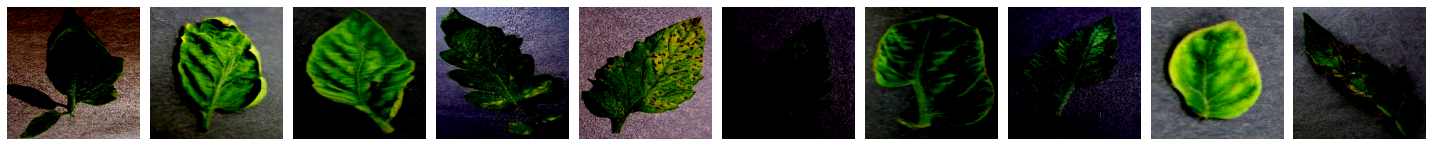

Tomato_yellow_leaf_curl_virus
Tomato_yellow_leaf_curl_virus
Tomato_yellow_leaf_curl_virus
Leaf_mold
Septorial_leaf_spot
Tomato_mosaic_virus
Tomato_yellow_leaf_curl_virus
Tomato_mosaic_virus
Tomato_yellow_leaf_curl_virus
Early_blight
Target_spot
Late_blight
Late_blight
Healthy
Tomato_yellow_leaf_curl_virus
Tomato_yellow_leaf_curl_virus
Healthy
Tomato_yellow_leaf_curl_virus
Tomato_yellow_leaf_curl_virus
Leaf_mold
Tomato_yellow_leaf_curl_virus
Target_spot
Tomato_mosaic_virus
Healthy
Tomato_yellow_leaf_curl_virus
Tomato_yellow_leaf_curl_virus
Healthy
Tomato_mosaic_virus
Late_blight
Tomato_yellow_leaf_curl_virus
Tomato_yellow_leaf_curl_virus
Septorial_leaf_spot


In [12]:
plotImages(imgs)
for i in labels:
    for j in range (len(i)):
        if i[j] == 1: print (classes[j])

# Build Model

# Use MobileNet as Feature Extractor

In [13]:
base_model=mobile.layers[-6].output
output = Dense(units=9, activation='softmax')(base_model)
model = Model(inputs=mobile.input, outputs=output)

# model = Sequential()
# for layer in vgg16_model.layers[:-1]:
#     model.add(layer)
# model.add(Dense(38, activation='softmax'))

In [14]:
for layer in model.layers[:-23]:
    layer.trainable = False

# for layer in model.layers[:10]:
#     layer.trainable = False

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

# Compile Model

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

# Train Model

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, batch_size=32, verbose=2)


# Predict with Model

In [ ]:
predictions = model.predict(x=test_batches, verbose=0)

# Plot Confusion Matrix

In [ ]:
plt.rcParams.update({'font.size': 100})
cm = confusion_matrix(y_true=test_batches.classes, normalize = 'true', y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = classes
fig, ax = plt.subplots(figsize=(200, 200))
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,  title='Confusion Matrix')

# Evaluate Model
We use F1 score alongside accuracy since this is an imbalanced dataset.

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_batches, batch_size=128)
print("test loss, test acc:", results)
#f1 = 2*[(precision*recall)/(precision+recall)]
print("Test F1 Score " + str(2*((0.9802*0.9787)/(0.9802+0.9787)))) 

In [ ]:
model.save("model.h5")

In [ ]:
!ls